## Import All Necessary Packages/Library

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import backend as K

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
FILE_PATH='data/riasec/labeled-data.csv'
CATEGORIES=['R','I','A','S','E','C']
INPUT_SHAPE=48
OUTPUT_SHAPE=6
LEARNING_RATE=0.0001
EPOCHS=100
BATCH_SIZE=256


## Preprocessing

In [3]:
df = pd.read_csv(FILE_PATH)
df.head()

,R1,R2,R3,R4,R5,R6,R7,R8,I1,I2,...,A_Score,S_Score,E_Score,C_Score,R_Prob,I_Prob,A_Prob,S_Prob,E_Prob,C_Prob
0,2,3,2,0,0,3,0,2,4,4,...,19,29,8,4,0.123711,0.257732,0.195876,0.298969,0.082474,0.041237
1,0,0,1,3,0,1,1,0,4,4,...,11,14,2,2,0.096774,0.435484,0.177419,0.225806,0.032258,0.032258
2,1,0,0,0,0,0,0,0,3,0,...,3,22,16,8,0.018868,0.056604,0.056604,0.415094,0.301887,0.150943
3,2,0,0,1,1,1,1,1,3,0,...,19,12,17,11,0.088608,0.164557,0.240506,0.151899,0.215190,0.139241
4,3,0,0,1,0,0,0,1,4,4,...,26,29,12,18,0.042373,0.237288,0.220339,0.245763,0.101695,0.152542


##### Convert label to biner format

In [4]:
feature_columns = [f'{col}{i}' for col in 'RIASEC' for i in range(1, 9)]
x = df[feature_columns]

label_columns = ['R_Prob','I_Prob','A_Prob','S_Prob','E_Prob','C_Prob']
y = pd.get_dummies(df[label_columns].idxmax(axis=1)).astype(int)
y = y.reindex(columns=label_columns, fill_value=0)

##### Split data to training and validation

In [5]:
x_train, x_test, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

print(f"Train data shape\t: {x_train.shape[:]}")
print(f"Val data  shape\t: {x_test.shape[:]}")
print(f"Train label shape\t: {y_train.shape[:]}")
print(f"Val label shape\t: {y_val.shape[:]}")

print(f"\nData training sample\t:\n,{x_train.head()}")
print(f"\nLabel training sample\t:\n,{y_train.head()}")

Train data shape	: (108611, 48)
Val data  shape	: (27153, 48)
Train label shape	: (108611, 6)
Val label shape	: (27153, 6)

Data training sample	:
,        R1  R2  R3  R4  R5  R6  R7  R8  I1  I2  ...  E7  E8  C1  C2  C3  C4  \
22808    0   0   0   2   0   0   0   0   3   3  ...   0   3   0   0   0   1   
83359    2   3   3   2   1   3   2   2   3   4  ...   2   4   2   4   3   1   
68299    0   0   0   0   0   0   0   0   0   1  ...   0   4   0   0   0   0   
110292   2   1   0   1   0   0   1   2   4   4  ...   2   3   3   4   1   2   
89050    0   0   0   0   0   1   0   0   3   0  ...   2   1   0   0   1   1   

        C5  C6  C7  C8  
22808    0   0   0   0  
83359    3   3   2   2  
68299    0   2   0   0  
110292   1   4   1   2  
89050    1   1   1   0  

[5 rows x 48 columns]

Label training sample	:
,        R_Prob  I_Prob  A_Prob  S_Prob  E_Prob  C_Prob
22808        0       1       0       0       0       0
83359        0       0       1       0       0       0
68299        

##### Check data distribution for each label

In [6]:
print(f"Training label distribution: {y_train.shape}")
print(y_train.sum())

print(f"\nValidation label distribution: {y_val.shape}")
print(y_val.sum())


Training label distribution: (108611, 6)
R_Prob     5569
I_Prob    30988
A_Prob    21069
S_Prob    35032
E_Prob     7263
C_Prob     8690
dtype: int64

Validation label distribution: (27153, 6)
R_Prob    1372
I_Prob    7649
A_Prob    5249
S_Prob    8828
E_Prob    1835
C_Prob    2220
dtype: int64


##### Downsampling data training and validation

In [7]:
def downsample(x, y, target_label):
    downsampled_x = []
    downsampled_y = []

    for label in y.columns:
        label_indices = y[label] == 1
        x_label = x[label_indices]
        y_label = y[label_indices]

        if label == 'R_Prob' or len(x_label) < target_label:
            downsampled_x.append(x_label)
            downsampled_y.append(y_label)
        else:
            x_resampled, y_resampled = resample(
                x_label, y_label,
                replace=False,
                n_samples=target_label,
                random_state=42
            )
            downsampled_x.append(x_resampled)
            downsampled_y.append(y_resampled)

    x_downsampled = pd.concat(downsampled_x, axis=0).reset_index(drop=True)
    y_downsampled = pd.concat(downsampled_y, axis=0).reset_index(drop=True)
    return x_downsampled, y_downsampled

In [8]:
x_train_balanced, y_train_balanced = downsample(x_train, y_train, 6000)
x_test_balanced, y_val_balanced = downsample(x_test, y_val, 1500)

print(f"Training label distribution: {y_train_balanced.shape}")
print(y_train_balanced.sum())

print(f"\nValidation label distribution: {y_val_balanced.shape}")
print(y_val_balanced.sum())


Training label distribution: (35569, 6)
R_Prob    5569
I_Prob    6000
A_Prob    6000
S_Prob    6000
E_Prob    6000
C_Prob    6000
dtype: int64

Validation label distribution: (8872, 6)
R_Prob    1372
I_Prob    1500
A_Prob    1500
S_Prob    1500
E_Prob    1500
C_Prob    1500
dtype: int64


## Model Building

In [9]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(INPUT_SHAPE,)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001), name='dense_layer_1'),
    # tf.keras.layers.Dropout(0.2, name='dropout_layer_1'),
    tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.0001), name='dense_layer_2'),
    # tf.keras.layers.Dropout(0.5, name='dropout_layer_2'),
    tf.keras.layers.Dense(OUTPUT_SHAPE, activation='softmax', name='output_layer')
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_layer_1 (Dense)       (None, 128)               6272      
                                                                 
 dense_layer_2 (Dense)       (None, 64)                8256      
                                                                 
 output_layer (Dense)        (None, 6)                 390       
                                                                 
Total params: 14918 (58.27 KB)
Trainable params: 14918 (58.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
history = model.fit(x_train_balanced, y_train_balanced, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_test_balanced, y_val_balanced), verbose=1)

Epoch 1/100
139/139 [==============================] - 1s 5ms/step - loss: 1.6349 - accuracy: 0.3753 - val_loss: 1.1415 - val_accuracy: 0.6305
Epoch 2/100
139/139 [==============================] - 0s 3ms/step - loss: 0.9096 - accuracy: 0.7114 - val_loss: 0.7113 - val_accuracy: 0.7820
Epoch 3/100
139/139 [==============================] - 0s 3ms/step - loss: 0.6064 - accuracy: 0.8100 - val_loss: 0.5109 - val_accuracy: 0.8443
Epoch 4/100
139/139 [==============================] - 1s 4ms/step - loss: 0.4598 - accuracy: 0.8605 - val_loss: 0.4071 - val_accuracy: 0.8777
Epoch 5/100
139/139 [==============================] - 1s 5ms/step - loss: 0.3756 - accuracy: 0.8904 - val_loss: 0.3435 - val_accuracy: 0.9036
Epoch 6/100
139/139 [==============================] - 1s 4ms/step - loss: 0.3219 - accuracy: 0.9101 - val_loss: 0.3000 - val_accuracy: 0.9196
Epoch 7/100
139/139 [==============================] - 1s 4ms/step - loss: 0.2843 - accuracy: 0.9242 - val_loss: 0.2677 - val_accuracy: 0.9303

In [13]:
results = model.evaluate(x_test, y_val)
print(f"Loss: {results[0]}, Accuracy: {results[1]}")

849/849 [==============================] - 2s 2ms/step - loss: 0.0589 - accuracy: 0.9912
Loss: 0.058877721428871155, Accuracy: 0.9911612272262573


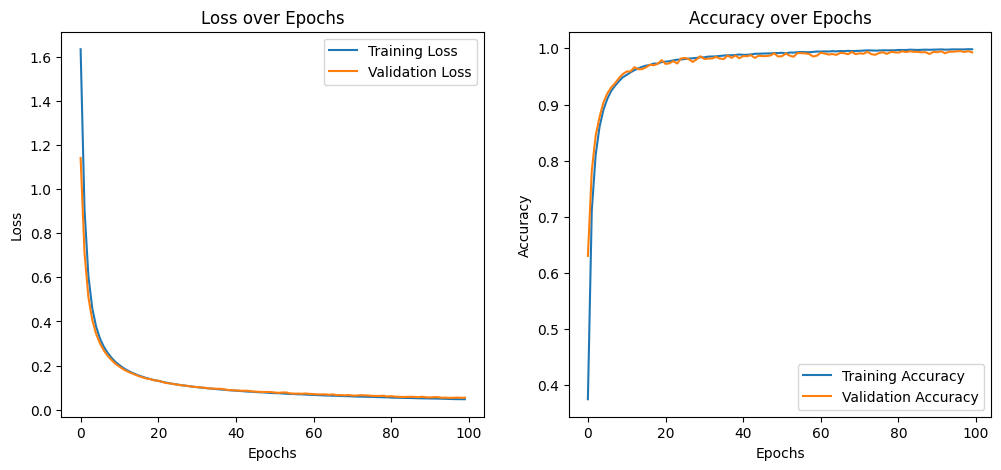

In [14]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss') 
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Validating Model Accuracy

In [22]:
y_pred_prob = model.predict(x_test_balanced)
y_pred = y_pred_prob.argmax(axis=1)

y_true = y_val_balanced.values.argmax(axis=1)

278/278 [==============================] - 0s 2ms/step


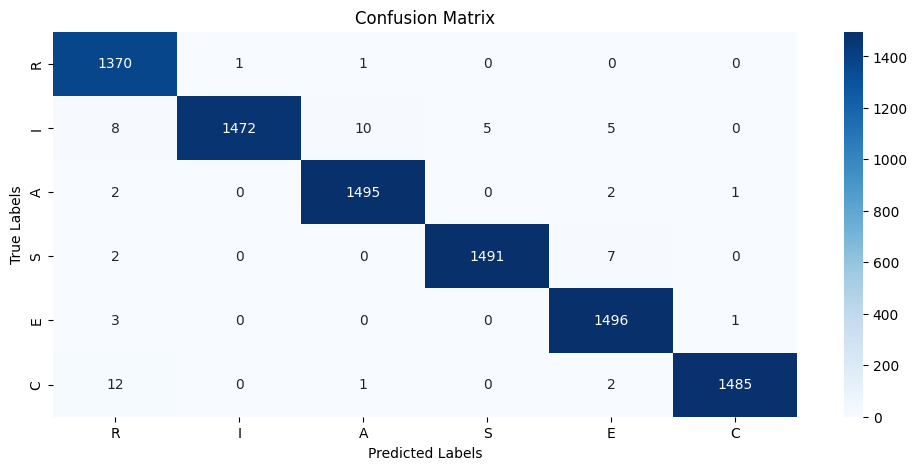

In [18]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [19]:
print(classification_report(y_true, y_pred, target_names=CATEGORIES))


              precision    recall  f1-score   support

           R       0.98      1.00      0.99      1372
           I       1.00      0.98      0.99      1500
           A       0.99      1.00      0.99      1500
           S       1.00      0.99      1.00      1500
           E       0.99      1.00      0.99      1500
           C       1.00      0.99      0.99      1500

    accuracy                           0.99      8872
   macro avg       0.99      0.99      0.99      8872
weighted avg       0.99      0.99      0.99      8872



## Testing on New Data

In [15]:
new_data = pd.read_csv('data/riasec/test.csv').loc[:, 'R1':'C8']
new_data.head()

,R1,R2,R3,R4,R5,R6,R7,R8,I1,I2,...,E7,E8,C1,C2,C3,C4,C5,C6,C7,C8
0,4,4,4,5,2,2,1,1,4,1,...,4,1,3,4,5,2,3,1,2,4
1,3,2,3,4,4,3,4,1,4,5,...,1,3,2,1,4,2,3,3,2,3
2,1,4,2,2,1,3,4,3,3,1,...,4,2,3,3,1,3,4,1,4,2
3,1,2,2,2,1,3,4,1,1,1,...,4,2,5,4,4,3,5,1,3,2
4,2,3,4,5,2,1,1,5,2,3,...,5,2,3,2,2,4,3,3,5,2


##### Model output (prediction)

In [23]:
predictions = model.predict(new_data[-1:]) #last row only
df_predictions = pd.DataFrame(predictions, columns=CATEGORIES)

binary_predictions = pd.get_dummies(df_predictions.idxmax(axis=1)).astype(int)
binary_predictions = binary_predictions.reindex(columns=CATEGORIES, fill_value=0)

print("Prediction Prob:\n", df_predictions)
print("\nBiner Prob:\n", binary_predictions)

print("\nRIASEC Category:")
for i, row in binary_predictions.iterrows():
    predicted_categories = [col for col in binary_predictions.columns if row[col] == 1]
    categories_string = ''.join(predicted_categories)

print(categories_string)

1/1 [==============================] - 0s 34ms/step
Prediction Prob:
               R             I             A    S             E             C
0  3.517560e-21  8.758800e-23  1.206206e-17  1.0  1.214180e-11  2.476234e-10

Biner Prob:
    R  I  A  S  E  C
0  0  0  0  1  0  0

RIASEC Category:
S


Optional: mapping predicted category to career recommendation

In [26]:
df_career = pd.read_csv('data/career/temp_riasec_professions.csv')

for predicted_category in categories_string:
    print(f"\nPredicted Category: {predicted_category}")
    
    matched_careers = df_career[df_career['Category'].str.contains(predicted_category)]
    
    if not matched_careers.empty:
        print("\nSuitable career:")
        for _, row in matched_careers.iterrows():
            print(f"- {row['Career']}")
    else:
        print("We can't find suitable careers for this category.")



Predicted Category: S

Suitable career:
- Dentist
- Firefighter
- Nurse
- Park Naturalist
- Personal trainer
- Physical therapy
- Sports medicine
- Wilderness medicine
- Surgeon
- Veterinarian
- Archivist
- Librarian
- Community Health Workers
- Counselor
- Dietitian
- Nutritionist
- Doctor
- Medical research
- Economics major
- Epidemiology
- Lawyer
- Pharmacist
- Psychologist
- Art therapist
- Social Worker
- Speech-language pathology
- Myofunctional therapist
- Tutor
- Clergy
- Entrepreneur
- Teacher
- Business trainer
- Translator
- Personal Financial Planner
- Community Organizer
- School Counselors
- Academic Advisors
- Career Counselors
- Consultants
- Customer service
- Educational administration
- Human Resources
- Social Advocate
- Sociology
- Social Worker
- Advisers
- Business
- Diplomacy
- Aerobics Teacher
- Fitness Trainer
- Sales
- Math teacher


## Save and Convert to TFLite

In [27]:
model.save('saved_model')

INFO:tensorflow:Assets written to: saved_model\assets


INFO:tensorflow:Assets written to: saved_model\assets


In [28]:
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model')
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)